In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import bioframe 
import pandas as pd
import numpy as np 
import os
import json
from io import StringIO
import random

import pysam
import h5py

from Bio import motifs
from Bio import pairwise2
from Bio.Seq import Seq

In [2]:
# In this version, a tsv / csv table with localization in the genome and orientation
# there's no need to provide information about orientation, or number of inserts

In [3]:
import sys

sys.path.insert(0, "/home1/smaruj/akita_utils/")

# from akita_utils import *
import akita_utils

2022-07-21 15:34:05.275813: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /spack/apps/linux-centos7-x86_64/gcc-8.3.0/python-3.9.2-uvcroioc4witkp6qf7mbebof5ix4wlb6/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/pmix-3.1.3-3sm6emyqaxapunh7rwbjvtaqoqe2e5z3/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/openmpi-4.0.2-ipm3dnvlbtxawpi4ifz7jma6jgr7mexq/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/openblas-0.3.8-2no6mfziiclwxb7lstxoos335gnhjpes/lib:/spack/apps/gcc/8.3.0/lib64::/home1/smaruj/software/GSL/lib:/home1/smaruj/software/HTSLIB/lib
2022-07-21 15:34:05.275847: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
genome_open = pysam.Fastafile("/project/fudenber_735/genomes/mm10/mm10.fa")

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
print("Tensorflow: ", tf.__version__)

from basenji import dataset, seqnn, dna_io, stream

Tensorflow:  2.9.1


In [6]:
# NOTE
# head_i = 0 #human
# head_i = 1 #mouse
#

head_i = 1 #mouse
# head_i = 0
model_num = 1 #which fold to use


#base_dir = '/project/fudenber_735/backup/DNN_HiC/human-mouse_5-16-21/'
#model_dir = base_dir+"/f"+str(model_num)+"_c0/train/"

base_dir = "/project/fudenber_735/tensorflow_models/akita/v2/models/"
model_dir = base_dir + "/f" + str(model_num) + "c0/train/"
model_file  = model_dir + "/model" + str(head_i) + "_best.h5"


# model_dir = '/home1/fudenber/repositories/basenji/manuscripts/akita/'
# model_file = model_dir+'/model_best.h5'

params_file = model_dir + "/params.json"
# params_file -> json (dict) with model's parameters
with open(params_file) as params_open:
    params = json.load(params_open)
    params_model = params["model"]
    params_train = params["train"]
seq_length = params_model["seq_length"]
params_model["verbose"] = False

seqnn_model = seqnn.SeqNN(params_model)
print("built")

seqnn_model.restore(model_file, head_i=head_i)    # model with the mouse head
print("restored")

print(seq_length)

2022-07-21 15:34:11.476820: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /spack/apps/linux-centos7-x86_64/gcc-8.3.0/python-3.9.2-uvcroioc4witkp6qf7mbebof5ix4wlb6/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/pmix-3.1.3-3sm6emyqaxapunh7rwbjvtaqoqe2e5z3/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/openmpi-4.0.2-ipm3dnvlbtxawpi4ifz7jma6jgr7mexq/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/openblas-0.3.8-2no6mfziiclwxb7lstxoos335gnhjpes/lib:/spack/apps/gcc/8.3.0/lib64::/home1/smaruj/software/GSL/lib:/home1/smaruj/software/HTSLIB/lib
2022-07-21 15:34:11.476867: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-21 15:34:11.476905: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (d11-08.hpc.usc.edu): /pro

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence (InputLayer)          [(None, 1310720, 4)  0           []                               
                                ]                                                                 
                                                                                                  
 stochastic_reverse_complement   ((None, 1310720, 4)  0          ['sequence[0][0]']               
 (StochasticReverseComplement)  , ())                                                             
                                                                                                  
 stochastic_shift (StochasticSh  (None, 1310720, 4)  0           ['stochastic_reverse_complement[0
 ift)                                                            ][0]']                     

In [7]:
hic_diags = params_model["diagonal_offset"]
try:
    target_crop = params_model["trunk"][-2]["cropping"]
except:
    target_crop = params_model["target_crop"]

print("hic_diags: ", hic_diags) 
print("target_crop: ", target_crop)
print("seq_length: ", seq_length)

target_length_cropped = int((seq_length//2048 - target_crop*2 - hic_diags) * ((seq_length//2048 - target_crop*2 - hic_diags) +1)/2) 
target_map_size = seq_length//2048  - target_crop*2 
triu_tup = np.triu_indices(target_map_size, 2)    # Return the indices for the upper-triangle of an (n, m) array, here k=2 (diagonal offset)
# target_map_size, target_length_cropped, triu_tup[0].shape

print("target_length_cropped: ", target_length_cropped)
print("target_map_size: ", target_map_size)
print("shape of triu_tup[0]: ", triu_tup[0].shape)

hic_diags:  2
target_crop:  64
seq_length:  1310720
target_length_cropped:  130305
target_map_size:  512
shape of triu_tup[0]:  (130305,)


In [8]:
background_file = base_dir + '../analysis/background_seqs.fa'
background_seqs = []
with open(background_file,'r') as f:
  for line in f.readlines():
    if '>' in line: continue
    background_seqs.append(dna_io.dna_1hot(line.strip())) 

In [9]:
len(background_seqs)

10

In [10]:
background_seqs = background_seqs[0:5]

In [11]:
len(background_seqs)

5

In [ ]:
# seq_coords_df = akita_utils.prepare_insertion_tsv(
#     h5_dirs = '/project/fudenber_735/tensorflow_models/akita/v2/analysis/permute_boundaries_motifs_ctcf_mm10_model*/scd.h5',
#     score_key = 'SCD',
#     pad_flank = 0, #how much flanking sequence around the sites to include
#     weak_thresh_pct = 1, # don't use sites weaker than this, might be artifacts
#     weak_num = 2 ,
#     strong_thresh_pct = 99, # don't use sites weaker than this, might be artifacts
#     strong_num = 2 ,
#     save_tsv=None, # optional filename to save a tsv
# )

In [ ]:
# padding = 20

In [ ]:
# num_inserts = 2
# one_side_radius = 100 
# spacer = one_side_radius - padding

In [ ]:
# motif_len = 19
# multi_insert_length = num_inserts * (motif_len + 2 * one_side_radius)
# print(multi_insert_length//num_inserts)

In [24]:
table_path = "/home1/smaruj/akita_utils/bin/out.csv"

In [26]:
table_path[-3:]

'csv'

In [13]:
seq_coords_df = pd.read_csv(table_path)

In [14]:
seq_coords_df

chrom      start        end strand  genomic_SCD orientation
0  chr12   35192359   35192378      -     53.66000          >>
1   chr8  102781112  102781131      -     53.50000         <><
2   chr7  139598311  139598330      +      0.05814          <>
3   chr8   45342919   45342938      +      0.05832        ><<<

In [15]:
def _insul_diamond_central(mat, window=10):
    """calculate insulation in a diamond around the central pixel"""
    N = mat.shape[0]
    if window > N // 2:
        raise ValueError("window cannot be larger than matrix")
    mid = N // 2
    lo = max(0, mid + 1 - window)
    hi = min(mid + window, N)
    score = np.nanmean(mat[lo : (mid + 1), mid:hi])
    return score

In [16]:
def plot_for_target(predictions, target_map_size, hic_diags, seq_nr, padding, saving=False, size=5, target = 0, vlim = .5, window = 50):
    
    nr_bg = predictions.shape[0]
    bin_mid = target_map_size//2
    
    plt.figure(figsize=(size, 2*size*nr_bg))

    for i in range(nr_bg):
        insert_pred = predictions[i]

        plt.subplot(1, nr_bg, i+1)
        im = plt.matshow(
                akita_utils.from_upper_triu(  
                insert_pred[:,target], target_map_size, hic_diags),
                vmin=-1*vlim, vmax=vlim, fignum=False,cmap='RdBu_r')
        plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.title('insert-scd: '+str(  np.sqrt( (insert_pred**2).sum(axis=0)  )[target] )
                 + '\n background: '+str(i)) 
    plt.tight_layout()
    if saving == True:
        plt.savefig(f"Seq-{seq_nr}_pad-{padding}.png")
    plt.show()
    

In [17]:

def multiple_padding(seq_coords_df, 
                     background_seqs, 
                     pad_list,
                     target_map_size, 
                     hic_diags,
                     head = 1, #mouse
                     stat = ["SCD, INS-18"],
                     verbose=True,
                     plotting=True,
                     saving=False, 
                     one_side_radius=100, 
                     motif_len=19):
    
    def split_arrows(string):
        char_list = []
        for char in string:
            char_list.append(char)
        return char_list
        
    nr_seq = len(seq_coords_df)
    nr_bg = len(background_seqs)
    
    nr_targets = 6
    
    if head == 0:  # human -> 5 targets
        nr_targets = 5
    
    nr_pads = len(pad_list)
        
    INS_windows = []
                
    for stat_matric in stat:
        if stat_matric[:3] == "INS":
            window = int(stat_matric.split("-")[1])
            INS_windows.append(window)
    
    INS_all_paddings = {}
    for window in INS_windows:
        INS_all_paddings[window] = np.zeros(shape=(nr_pads, nr_seq, nr_bg, nr_targets))
                
    # if "SCD" in stat_matric:
    SCD_all_paddings = np.zeros(shape=(nr_pads, nr_seq, nr_bg, nr_targets))
    
    for p in range(len(pad_list)):
        
        padding = pad_list[p]
        
        print(f"padding = {padding} || Started working on padding = {padding}")
                
        INS_all_sequences = {}
        for window in INS_windows:
            INS_all_sequences[window] = np.zeros(shape=(nr_seq, nr_bg, nr_targets))
                
        # if "SCD" in stat_matric:
        SCD_all_sequences = np.zeros(shape=(nr_seq, nr_bg, nr_targets))
        
        
        for i in seq_coords_df.index:      #iteraton over sequences
            
            orientation_string = seq_coords_df.iloc[i].orientation
            orientation_list = split_arrows(orientation_string)
            num_inserts = len(orientation_string)
            
            print(orientation_list)
            
            print(orientation_string)
            print(type(orientation_string))
            print(num_inserts)
            
            spacer = one_side_radius - padding
            
            multi_insert_length = num_inserts * (motif_len + 2 * one_side_radius)
            
            offsets = []

            for i in range(num_inserts):
                offsets.append( seq_length//2 - multi_insert_length//2 + i * (multi_insert_length//2) + spacer)
            
            # print(offsets)
            
            all_inserts = []

            for bi in range(len(background_seqs)):
                seq_1hot = background_seqs[bi].copy()
                this_row = seq_coords_df.iloc[i]
                
                # CTCF motif in the ">" orientation (heading right)
                seq_1hot_CTCF_pad_right = dna_io.dna_1hot(genome_open.fetch(this_row.chrom, this_row.start-padding, this_row.end+padding).upper())

                if this_row.strand == '-': 
                    seq_1hot_CTCF_pad_right = dna_io.hot1_rc(seq_1hot_CTCF_pad_right)
                
                # CTCF motif in the "<" orientation (headin left)
                seq_1hot_CTCF_pad_left = dna_io.hot1_rc(seq_1hot_CTCF_pad_right)
                
                for o in range(len(offsets)):
                    offset = offsets[o]
                    
                    if orientation_list[o] == ">":
                        seq_1hot[offset : offset + len(seq_1hot_CTCF_pad_right)] = seq_1hot_CTCF_pad_right
                    
                    else: # "<"
                        seq_1hot[offset : offset + len(seq_1hot_CTCF_pad_left)] = seq_1hot_CTCF_pad_left
                    
                all_inserts.append(seq_1hot)
                
            all_inserts = np.array(all_inserts) 

            print(all_inserts.shape) 

            pred = seqnn_model.predict(all_inserts, batch_size=10)  

            print(pred.shape) 
            
            INS_all_backgrounds = {}
            for window in INS_windows:
                INS_all_backgrounds[window] = np.zeros(shape=(nr_bg, nr_targets))
                
            # if "SCD" in stat_matric:
            SCD_all_backgrounds = np.zeros(shape=(nr_bg, nr_targets))
            
            
            for bi in range(nr_bg):      # iteration over background sequences
                
                insert_pred = pred[bi]
                
                if verbose == True:
                
                    print("\n**********")
                    print("Padding: ", padding, "\nSequence: ", i, "\nBackground: ", bi, "\nSCD averaged over targets: ", np.sqrt( (insert_pred**2).sum(axis=0)  ).mean())
                    print("**********\n")

                    print("Metrics: ")
                                                
                INS_all_targets = {}
                for window in INS_windows:
                    INS_all_targets[window] = np.zeros(insert_pred.shape[1])
                
                # if "SCD" in stat_matric:
                SCD_all_targets = np.zeros(insert_pred.shape[1])
                
                for target_ind in range(insert_pred.shape[1]):       # iteration over targets

                    # print(target_ind, "SCD: ", np.sqrt( (insert_pred**2).sum(axis=0))[target_ind])
                    
                    INS_dict = {}
                    mat = akita_utils.from_upper_triu(insert_pred[:,target_ind], target_map_size, hic_diags)
                    
                    for stat_matric in stat:
                                            
                        if stat_matric == "SCD":
                    
                            SCD = np.sqrt( (insert_pred**2).sum(axis=0))[target_ind]      # sequence = i background = bi, target = target_ind
                            SCD_all_targets[target_ind] = SCD
                            
                            if verbose == True:
                                print("target_ind: ", target_ind, "SCD: ", np.sqrt( (insert_pred**2).sum(axis=0))[target_ind])
                        
                        elif stat_matric[:3] == "INS":
                            
                            window = int(stat_matric.split("-")[1])
                            
                            INS_all_targets[window][target_ind] = _insul_diamond_central(mat, window=window)
                            
                            if verbose == True:
                                print("target_ind: ", target_ind, f"INS-{window}: ", INS_all_targets[window][target_ind])
                
                # print(SCD_all_targets)
                # print(INS_all_targets)
                
                for window in INS_windows:
                    INS_all_backgrounds[window][bi] = INS_all_targets[window]
                
                SCD_all_backgrounds[bi] = SCD_all_targets
                
            print(f"padding = {padding} || Plotting")
            
            if plotting == True:
                
                for target_i in range(pred.shape[2]):
                    print(target_i)
                    plot_for_target(pred, target_map_size=target_map_size, hic_diags=hic_diags, seq_nr=i, padding=padding, size=15, target=target_i)
                    
                    if saving == True:
                        plot_for_target(pred, target_map_size=target_map_size, hic_diags=hic_diags, seq_nr=i, padding=padding, saving=True, size=15, target=target_i)
                                    
            # print(SCD_all_backgrounds)
            # for window in INS_windows:
            #     print(INS_all_backgrounds[window])
            
            for window in INS_windows:
                INS_all_sequences[window][i] = INS_all_backgrounds[window]
                
            SCD_all_sequences[i] = SCD_all_backgrounds
                
        # print("INS_all_sequences ", INS_all_sequences)
        # print("SCD_all_sequences ", SCD_all_sequences)
        
        
        for window in INS_windows:
            INS_all_paddings[window][p] = INS_all_sequences[window]
                
        SCD_all_paddings[p] = SCD_all_sequences
        
    # print(SCD_all_paddings.shape)
    # for window in INS_windows:
    #     print(INS_all_paddings[window].shape)
    
    return(SCD_all_paddings, INS_all_paddings)


In [18]:
pad_list = [k for k in range(0, 2)]

padding = 0 || Started working on padding = 0
['>', '>']
>>
<class 'str'>
2
(5, 1310720, 4)
1/1 [==============================] - 8s 8s/step
(5, 130305, 6)

**********
Padding:  0 
Sequence:  1 
Background:  0 
SCD averaged over targets:  14.3
**********

Metrics: 
target_ind:  0 SCD:  13.63
target_ind:  0 INS-18:  -0.15288945373345014
target_ind:  1 SCD:  16.0
target_ind:  1 INS-18:  -0.16714772257106697
target_ind:  2 SCD:  16.0
target_ind:  2 INS-18:  -0.15133952203198014
target_ind:  3 SCD:  12.85
target_ind:  3 INS-18:  -0.13729620722595404
target_ind:  4 SCD:  16.0
target_ind:  4 INS-18:  -0.14564528420706777
target_ind:  5 SCD:  11.31
target_ind:  5 INS-18:  -0.11452277352876752

**********
Padding:  0 
Sequence:  1 
Background:  1 
SCD averaged over targets:  13.66
**********

Metrics: 
target_ind:  0 SCD:  11.31
target_ind:  0 INS-18:  -0.15955996884735202
target_ind:  1 SCD:  16.0
target_ind:  1 INS-18:  -0.15981171509929906
target_ind:  2 SCD:  16.0
target_ind:  2 INS-18:  

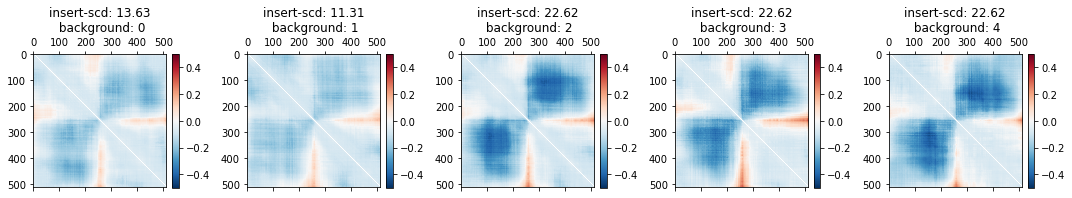

1


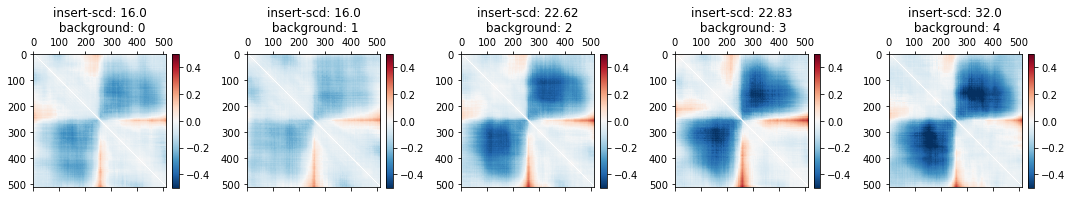

2


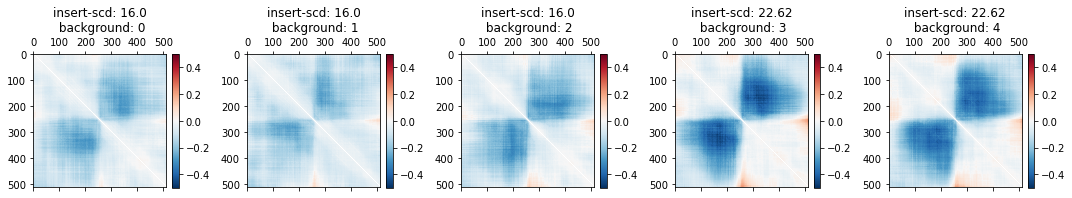

3


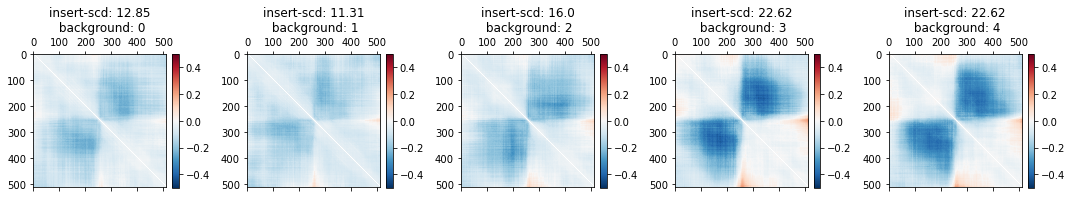

4


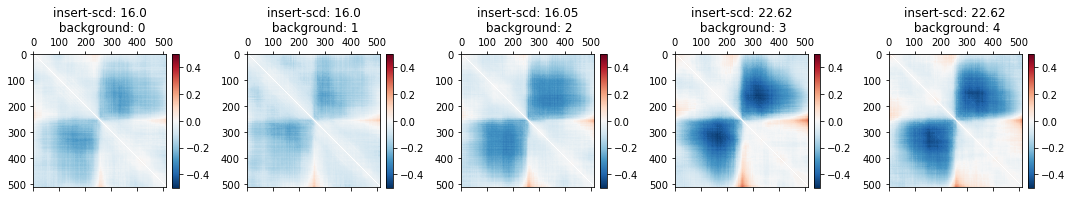

5


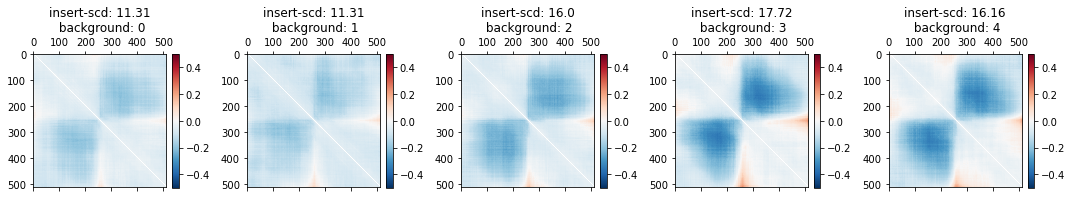

['<', '>', '<']
<><
<class 'str'>
3
(5, 1310720, 4)
1/1 [==============================] - 6s 6s/step
(5, 130305, 6)

**********
Padding:  0 
Sequence:  2 
Background:  0 
SCD averaged over targets:  7.61
**********

Metrics: 
target_ind:  0 SCD:  8.0
target_ind:  0 INS-18:  -0.06464935017523364
target_ind:  1 SCD:  8.0
target_ind:  1 INS-18:  -0.03137247436143156
target_ind:  2 SCD:  8.0
target_ind:  2 INS-18:  -0.05746859256352219
target_ind:  3 SCD:  8.0
target_ind:  3 INS-18:  -0.06753920320409852
target_ind:  4 SCD:  8.0
target_ind:  4 INS-18:  -0.042784456152039525
target_ind:  5 SCD:  5.656
target_ind:  5 INS-18:  -0.056859381845064255

**********
Padding:  0 
Sequence:  2 
Background:  1 
SCD averaged over targets:  8.91
**********

Metrics: 
target_ind:  0 SCD:  10.23
target_ind:  0 INS-18:  -0.08010502990532516
target_ind:  1 SCD:  10.89
target_ind:  1 INS-18:  -0.03760830412772586
target_ind:  2 SCD:  8.195
target_ind:  2 INS-18:  -0.038644618334428546
target_ind:  3 SCD:  8

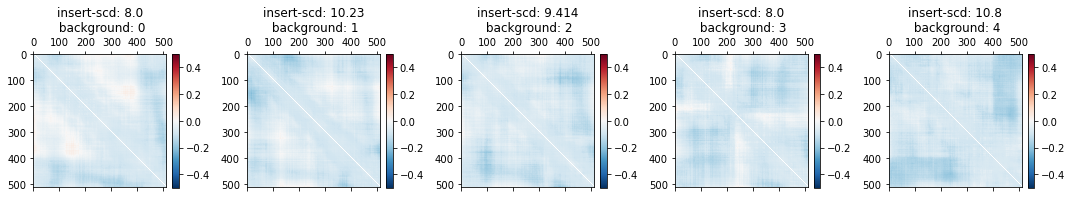

1


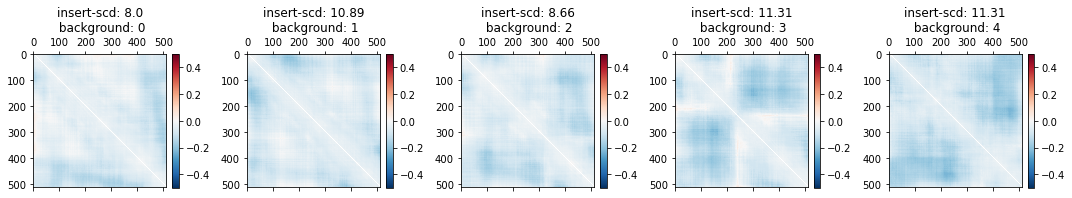

2


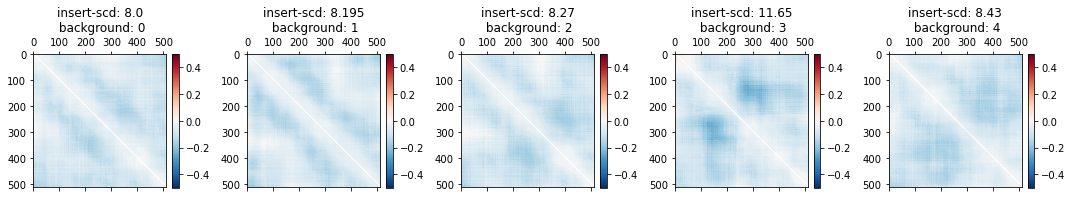

3


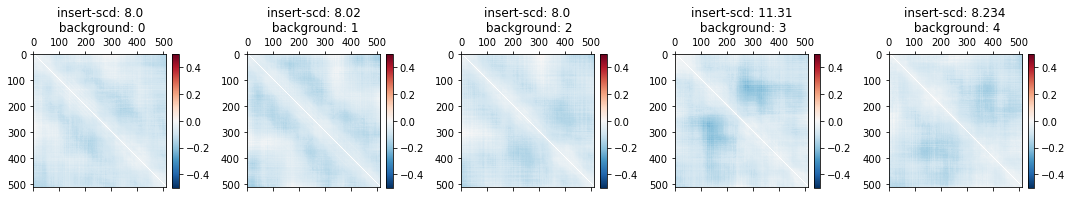

4


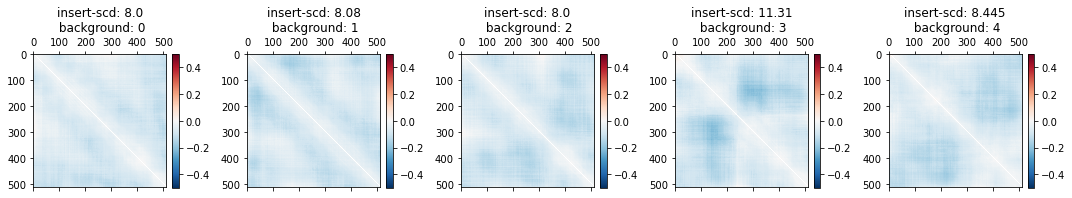

5


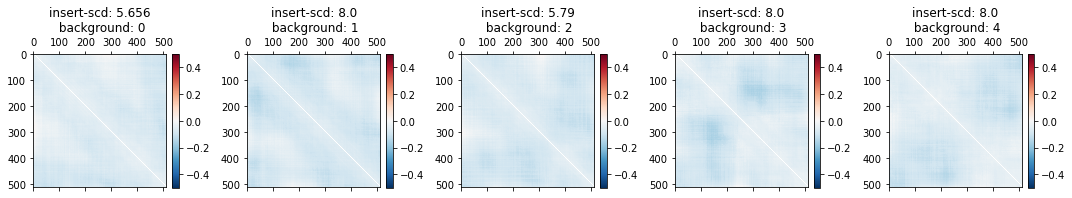

['<', '>']
<>
<class 'str'>
2
(5, 1310720, 4)
1/1 [==============================] - 6s 6s/step
(5, 130305, 6)

**********
Padding:  0 
Sequence:  1 
Background:  0 
SCD averaged over targets:  19.83
**********

Metrics: 
target_ind:  0 SCD:  16.0
target_ind:  0 INS-18:  -0.18537536811234423
target_ind:  1 SCD:  22.62
target_ind:  1 INS-18:  -0.22198029990508178
target_ind:  2 SCD:  22.62
target_ind:  2 INS-18:  -0.20006031262169002
target_ind:  3 SCD:  19.11
target_ind:  3 INS-18:  -0.17853201512607086
target_ind:  4 SCD:  22.62
target_ind:  4 INS-18:  -0.1958000206873053
target_ind:  5 SCD:  16.0
target_ind:  5 INS-18:  -0.14929085134345793

**********
Padding:  0 
Sequence:  1 
Background:  1 
SCD averaged over targets:  13.516
**********

Metrics: 
target_ind:  0 SCD:  11.31
target_ind:  0 INS-18:  -0.16162299515673675
target_ind:  1 SCD:  16.0
target_ind:  1 INS-18:  -0.15833280093944704
target_ind:  2 SCD:  15.43
target_ind:  2 INS-18:  -0.12757288852584697
target_ind:  3 SCD:  1

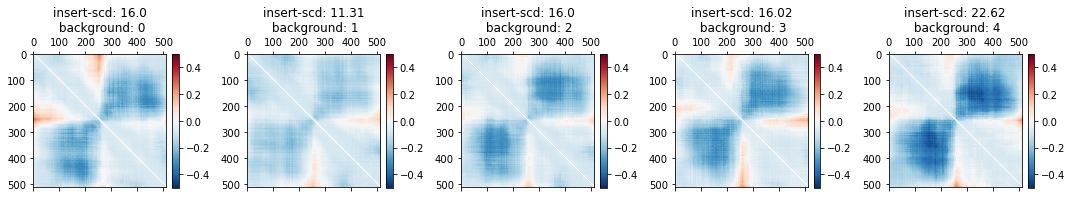

1


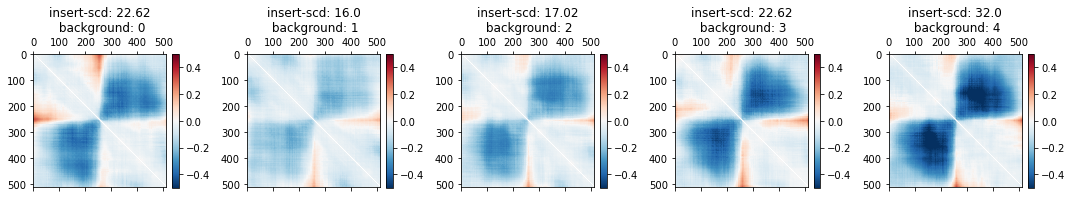

2


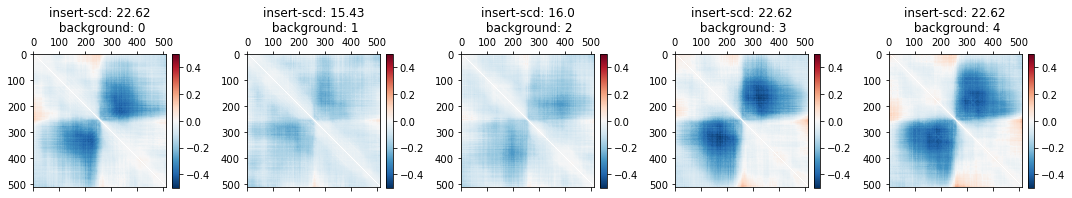

3


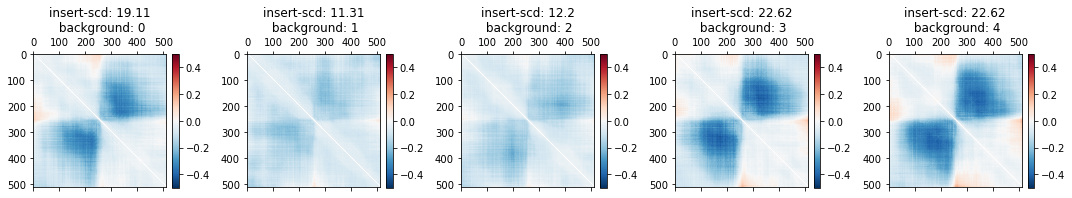

4


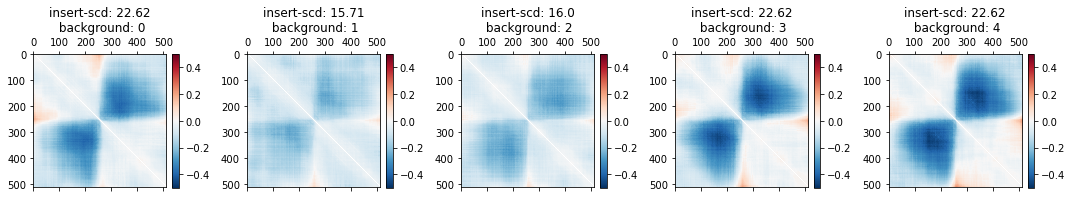

5


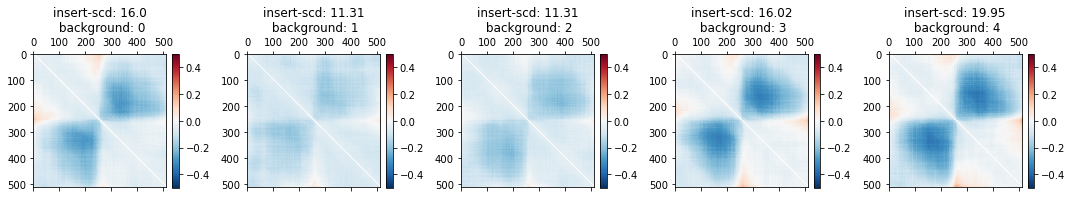

['>', '<', '<', '<']
><<<
<class 'str'>
4
(5, 1310720, 4)
1/1 [==============================] - 6s 6s/step
(5, 130305, 6)

**********
Padding:  0 
Sequence:  3 
Background:  0 
SCD averaged over targets:  7.61
**********

Metrics: 
target_ind:  0 SCD:  8.0
target_ind:  0 INS-18:  -0.06480393454293225
target_ind:  1 SCD:  8.0
target_ind:  1 INS-18:  -0.03159215814227998
target_ind:  2 SCD:  8.0
target_ind:  2 INS-18:  -0.05785415031456873
target_ind:  3 SCD:  8.0
target_ind:  3 INS-18:  -0.06799877321237344
target_ind:  4 SCD:  8.0
target_ind:  4 INS-18:  -0.043097356398157614
target_ind:  5 SCD:  5.656
target_ind:  5 INS-18:  -0.05719260337568147

**********
Padding:  0 
Sequence:  3 
Background:  1 
SCD averaged over targets:  8.91
**********

Metrics: 
target_ind:  0 SCD:  10.234
target_ind:  0 INS-18:  -0.0803655226282613
target_ind:  1 SCD:  10.91
target_ind:  1 INS-18:  -0.03816460820373345
target_ind:  2 SCD:  8.195
target_ind:  2 INS-18:  -0.03962517378857574
target_ind:  3 SCD

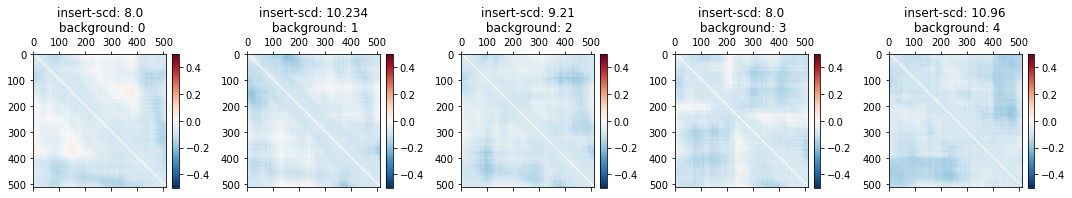

1


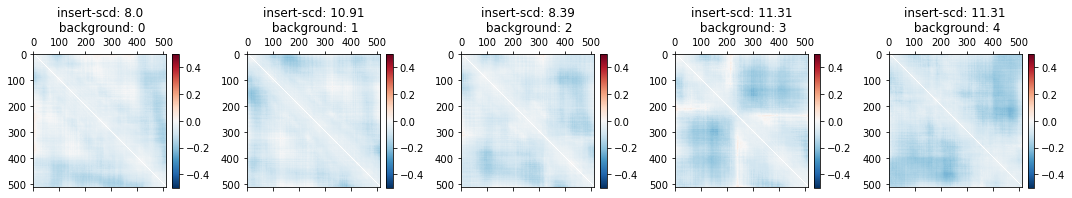

2


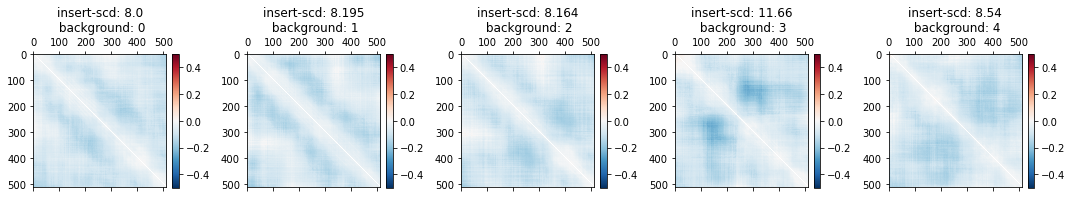

3


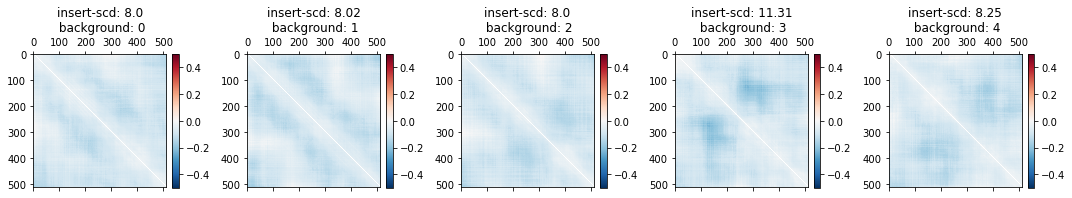

4


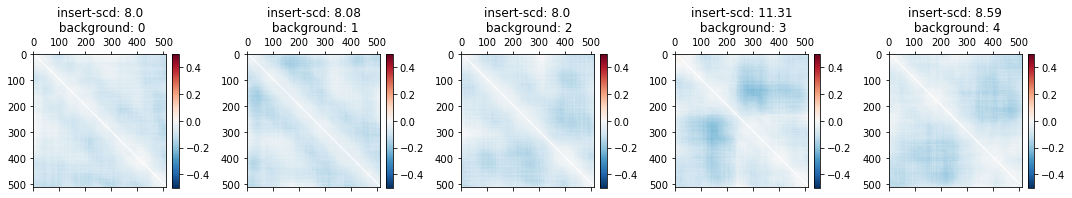

5


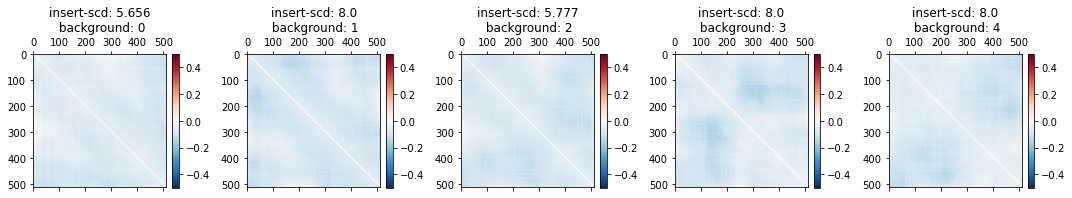

padding = 1 || Started working on padding = 1
['>', '>']
>>
<class 'str'>
2
(5, 1310720, 4)
1/1 [==============================] - 6s 6s/step
(5, 130305, 6)

**********
Padding:  1 
Sequence:  1 
Background:  0 
SCD averaged over targets:  15.25
**********

Metrics: 
target_ind:  0 SCD:  16.0
target_ind:  0 INS-18:  -0.15939112392912771
target_ind:  1 SCD:  16.2
target_ind:  1 INS-18:  -0.17800722686672507
target_ind:  2 SCD:  16.0
target_ind:  2 INS-18:  -0.16534233687451325
target_ind:  3 SCD:  16.0
target_ind:  3 INS-18:  -0.14904728114047897
target_ind:  4 SCD:  16.0
target_ind:  4 INS-18:  -0.15843091352706387
target_ind:  5 SCD:  11.31
target_ind:  5 INS-18:  -0.12310334678008178

**********
Padding:  1 
Sequence:  1 
Background:  1 
SCD averaged over targets:  13.64
**********

Metrics: 
target_ind:  0 SCD:  11.31
target_ind:  0 INS-18:  -0.16030170761536214
target_ind:  1 SCD:  15.9
target_ind:  1 INS-18:  -0.1598430883104556
target_ind:  2 SCD:  16.0
target_ind:  2 INS-18:  -0

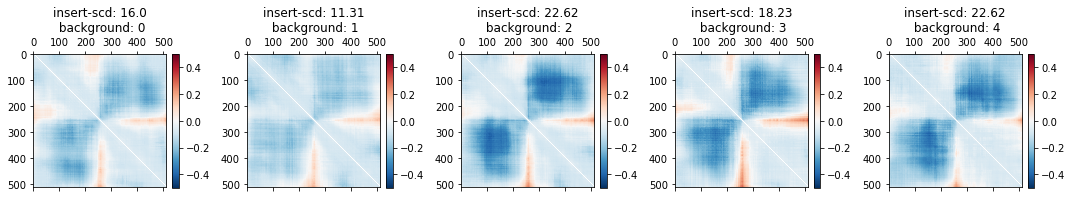

1


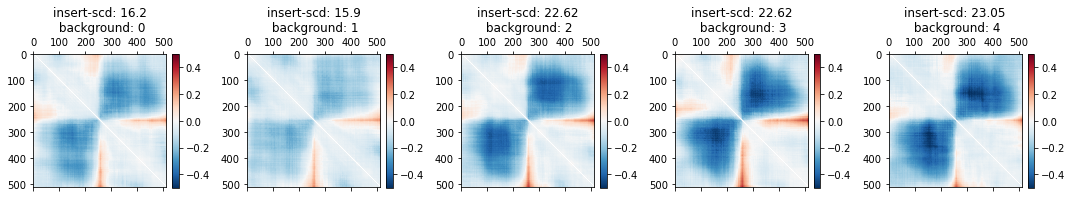

2


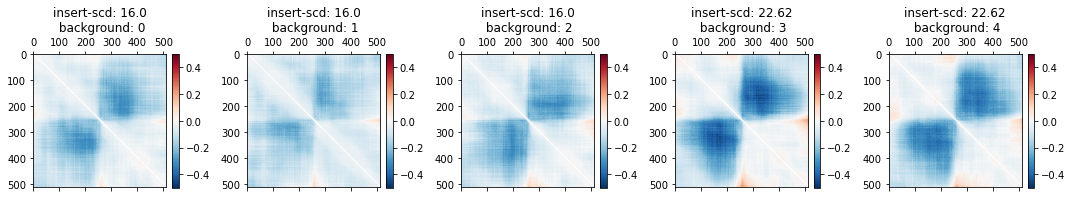

3


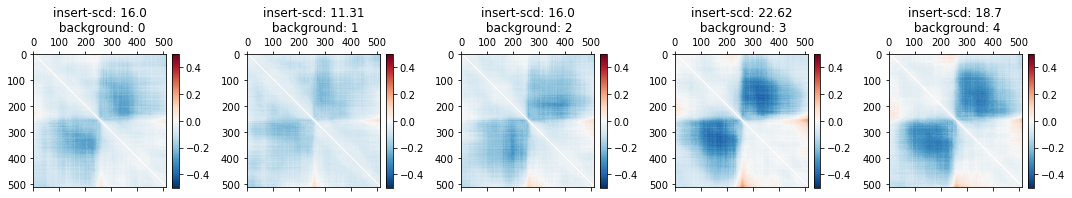

4


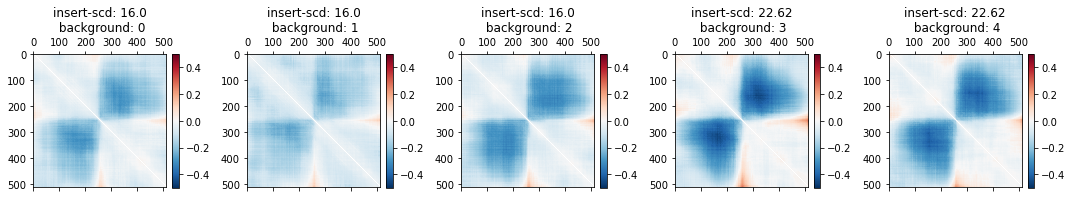

5


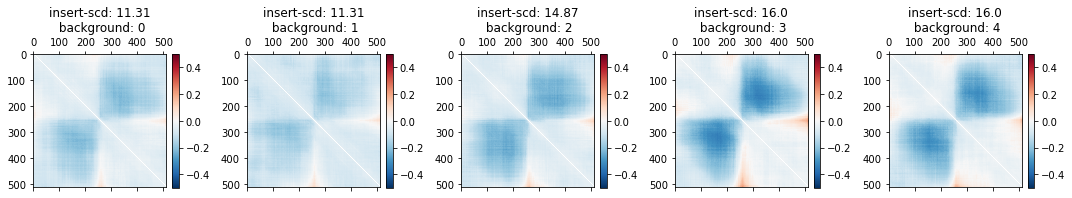

['<', '>', '<']
<><
<class 'str'>
3
(5, 1310720, 4)
1/1 [==============================] - 6s 6s/step
(5, 130305, 6)

**********
Padding:  1 
Sequence:  2 
Background:  0 
SCD averaged over targets:  7.61
**********

Metrics: 
target_ind:  0 SCD:  8.0
target_ind:  0 INS-18:  -0.06448982215001947
target_ind:  1 SCD:  8.0
target_ind:  1 INS-18:  -0.0312795193395882
target_ind:  2 SCD:  8.0
target_ind:  2 INS-18:  -0.05770032650956484
target_ind:  3 SCD:  8.0
target_ind:  3 INS-18:  -0.06776366426937305
target_ind:  4 SCD:  8.0
target_ind:  4 INS-18:  -0.042831206990179616
target_ind:  5 SCD:  5.656
target_ind:  5 INS-18:  -0.0568915156189155

**********
Padding:  1 
Sequence:  2 
Background:  1 
SCD averaged over targets:  8.91
**********

Metrics: 
target_ind:  0 SCD:  10.234
target_ind:  0 INS-18:  -0.08029764240775895
target_ind:  1 SCD:  10.89
target_ind:  1 INS-18:  -0.03784146412882107
target_ind:  2 SCD:  8.195
target_ind:  2 INS-18:  -0.03868583132544782
target_ind:  3 SCD:  8.02

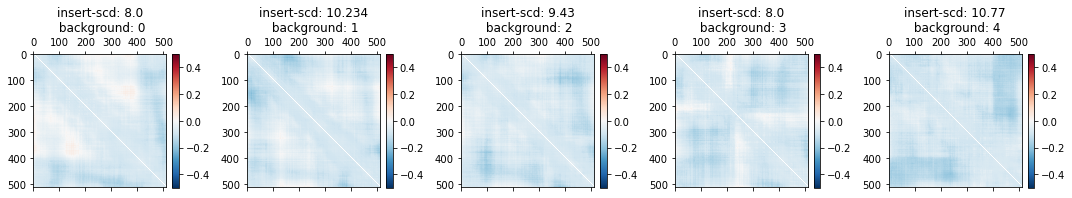

1


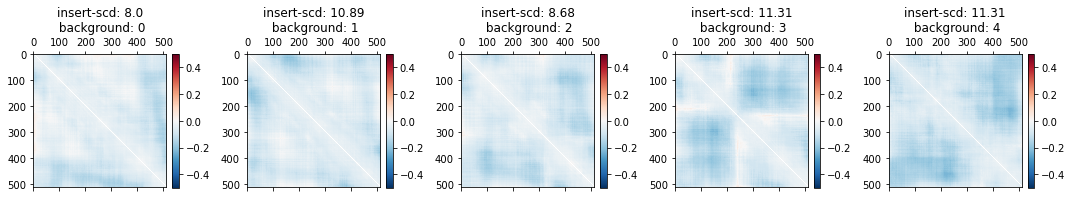

2


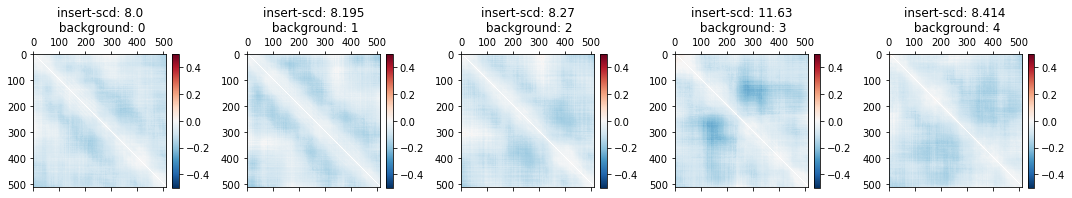

3


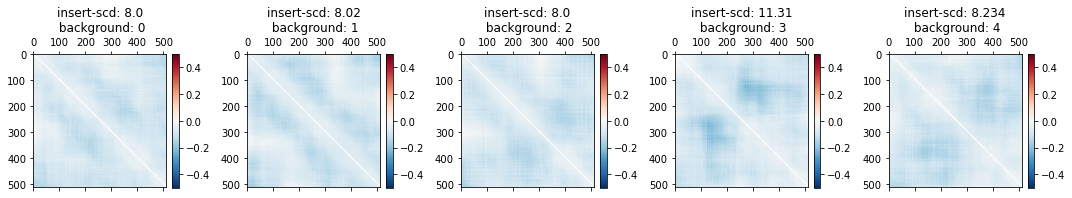

4


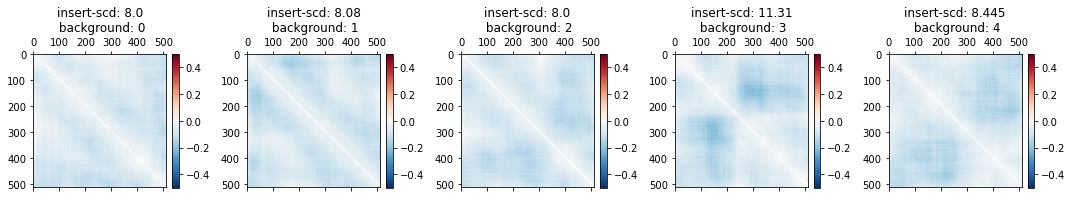

5


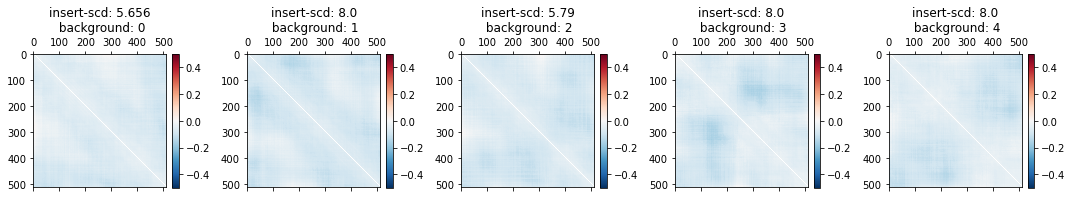

['<', '>']
<>
<class 'str'>
2
(5, 1310720, 4)
1/1 [==============================] - 6s 6s/step
(5, 130305, 6)

**********
Padding:  1 
Sequence:  1 
Background:  0 
SCD averaged over targets:  19.33
**********

Metrics: 
target_ind:  0 SCD:  16.0
target_ind:  0 INS-18:  -0.17581661616530375
target_ind:  1 SCD:  22.62
target_ind:  1 INS-18:  -0.20386027398510514
target_ind:  2 SCD:  22.62
target_ind:  2 INS-18:  -0.18389474268642914
target_ind:  3 SCD:  16.08
target_ind:  3 INS-18:  -0.16441616165303738
target_ind:  4 SCD:  22.62
target_ind:  4 INS-18:  -0.1793748136621398
target_ind:  5 SCD:  16.0
target_ind:  5 INS-18:  -0.13809993185358255

**********
Padding:  1 
Sequence:  1 
Background:  1 
SCD averaged over targets:  11.71
**********

Metrics: 
target_ind:  0 SCD:  11.31
target_ind:  0 INS-18:  -0.15914964527355918
target_ind:  1 SCD:  13.19
target_ind:  1 INS-18:  -0.1520910530446846
target_ind:  2 SCD:  11.45
target_ind:  2 INS-18:  -0.11661707797897196
target_ind:  3 SCD:  11

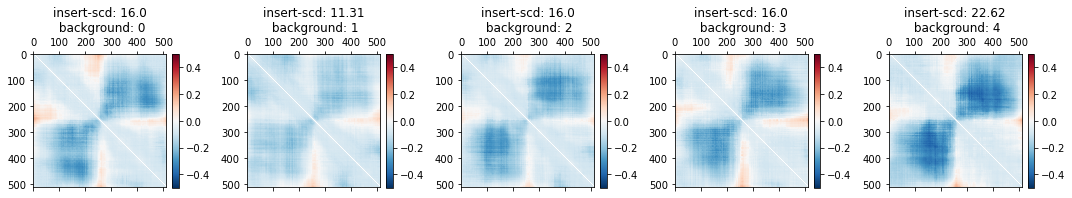

1


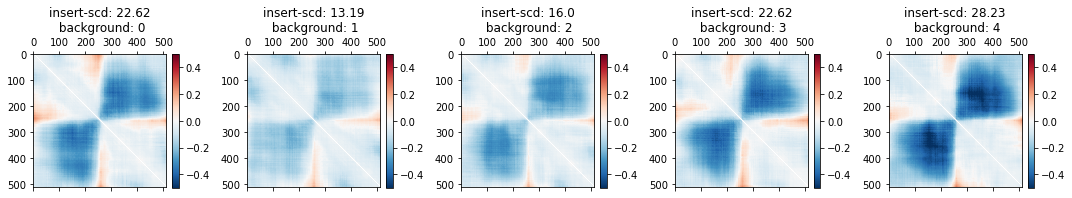

2


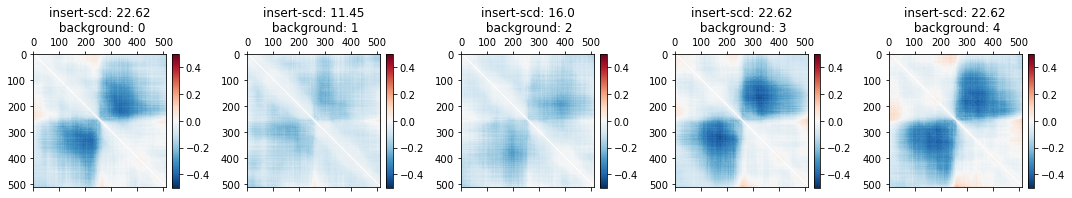

3


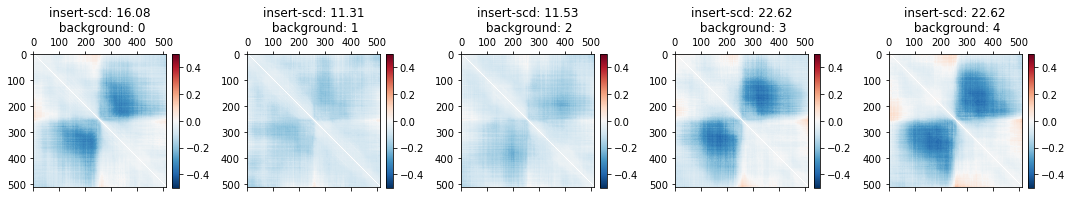

4


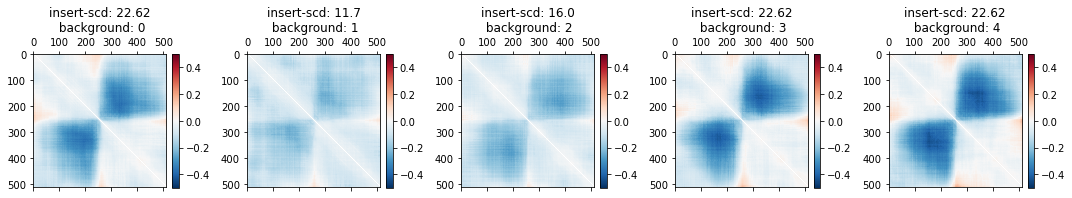

5


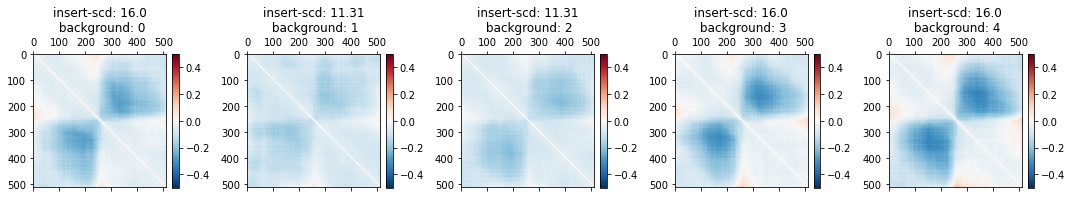

['>', '<', '<', '<']
><<<
<class 'str'>
4
(5, 1310720, 4)
1/1 [==============================] - 6s 6s/step
(5, 130305, 6)

**********
Padding:  1 
Sequence:  3 
Background:  0 
SCD averaged over targets:  7.61
**********

Metrics: 
target_ind:  0 SCD:  8.0
target_ind:  0 INS-18:  -0.06475991697697625
target_ind:  1 SCD:  8.0
target_ind:  1 INS-18:  -0.03153128935911945
target_ind:  2 SCD:  8.0
target_ind:  2 INS-18:  -0.05799418892073111
target_ind:  3 SCD:  8.0
target_ind:  3 INS-18:  -0.06809080129843263
target_ind:  4 SCD:  8.0
target_ind:  4 INS-18:  -0.04311610902209891
target_ind:  5 SCD:  5.656
target_ind:  5 INS-18:  -0.05715685692903037

**********
Padding:  1 
Sequence:  3 
Background:  1 
SCD averaged over targets:  8.91
**********

Metrics: 
target_ind:  0 SCD:  10.234
target_ind:  0 INS-18:  -0.0804178113135222
target_ind:  1 SCD:  10.89
target_ind:  1 INS-18:  -0.037881773951640385
target_ind:  2 SCD:  8.195
target_ind:  2 INS-18:  -0.03864452326409171
target_ind:  3 SCD

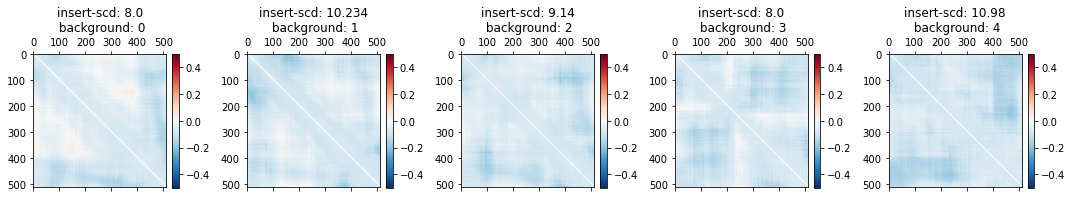

1


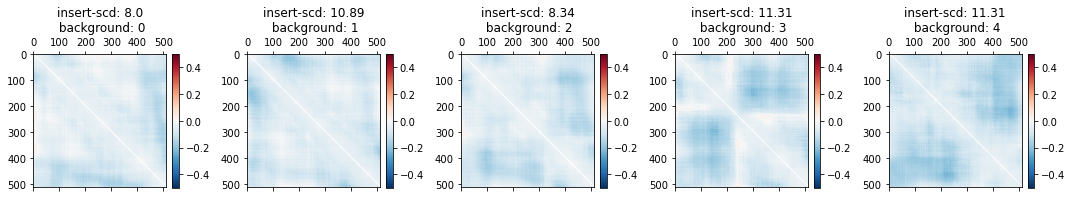

2


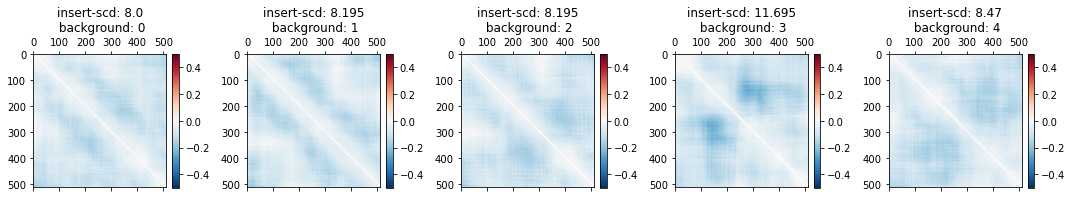

3


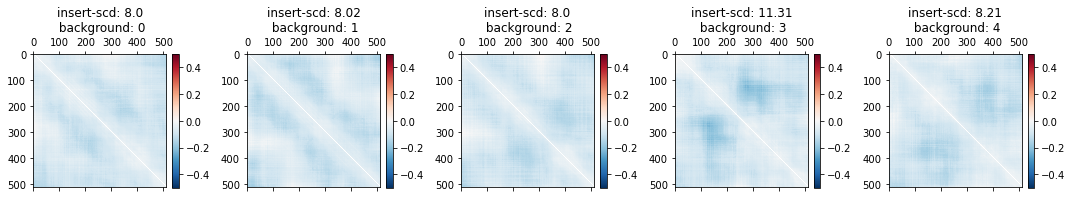

4


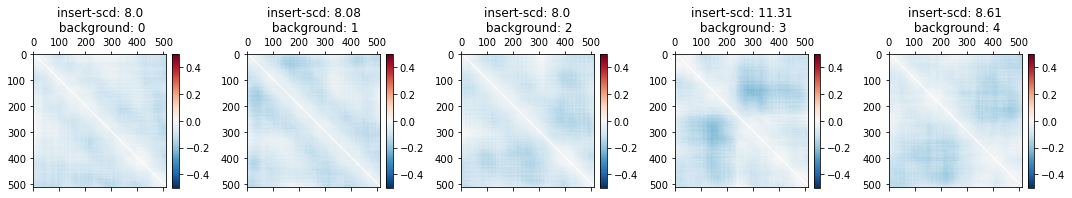

5


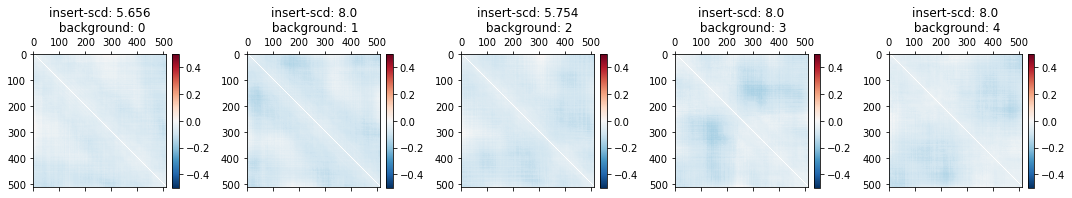

In [19]:
duap = multiple_padding(seq_coords_df, 
                     background_seqs, 
                     pad_list,
                     target_map_size, 
                     hic_diags,
                     head = 1, #mouse
                     stat = ["SCD", "INS-18"],
                     verbose=True,
                     plotting=True,
                     saving=False, 
                     one_side_radius=100, 
                     motif_len=19)

In [20]:
duap[0].shape
# 1st dim - numer of paddings tested
# 2nd dim - number of sequences
# 3rd dim - number of background sequences
# 4th dim - number of targets

(2, 4, 5, 6)

In [ ]:
# seq_coords_df.to_csv("./50-60pads_divergent.csv", index=False)

In [22]:
def save_h5(seq_coords_df, out_dir, filename, stat, prediction):
    chrom = seq_coords_df.chrom.to_numpy()
    start = seq_coords_df.start.to_numpy().astype(np.int32)
    end = seq_coords_df.end.to_numpy().astype(np.int32)
    strand = seq_coords_df.strand.to_numpy()
    genSCD = seq_coords_df.genomic_SCD.to_numpy().astype(np.float64)
    
    with h5py.File(out_dir + "/" + filename, "w") as hf:
        hf.create_dataset("SCD",  data=prediction[0])
        for key in prediction[1]:
            hf.create_dataset("INS-" + str(key),  data=prediction[1][key])
        hf.create_dataset("Chromosome",  data=chrom.astype('S'))
        hf.create_dataset("Start",  data=start)
        hf.create_dataset("End",  data=end)
        hf.create_dataset("Strand",  data=strand.astype('S'))
        hf.create_dataset("genomic_SCD",  data=genSCD)

In [23]:
save_h5(seq_coords_df=seq_coords_df, 
        out_dir=".", 
        filename="test.h5", 
        stat=["SCD", "INS-18"], 
        prediction=duap)

In [ ]:
# import h5py

# with h5py.File('test.h5', 'w') as hf:
#     hf.create_dataset("SCD",  data=duap[0])
#     for key in duap[1]:
#         hf.create_dataset("INS-" + str(key),  data=duap[0])
#     hf.create_dataset("Chromosome",  data=chrom.astype('S'))
#     hf.create_dataset("Start",  data=start)
#     hf.create_dataset("End",  data=end)
#     hf.create_dataset("Strand",  data=strand.astype('S'))
#     hf.create_dataset("genomic_SCD",  data=genSCD)

In [ ]:
# offsets = []

# print(seq_length//2)
# print(seq_length//2 - multi_insert_length//2)
# for i in range(num_inserts):
#     offsets.append( seq_length//2 - multi_insert_length//2 + i * (multi_insert_length//2) + spacer)
# print(offsets)

In [ ]:
# all_inserts = []

# # inserting only to the first background sequence
# for background_seq in background_seqs:
#     for i in seq_coords_df.index:
#         seq_1hot = background_seq.copy()
#         this_row = seq_coords_df.iloc[i]
#         seq_1hot_CTCF_pad = dna_io.dna_1hot(genome_open.fetch(this_row.chrom, this_row.start-padding, this_row.end+padding).upper())
#         if this_row.strand == '-': 
#             seq_1hot_CTCF_pad = dna_io.hot1_rc(seq_1hot_CTCF_pad)
#         # print(this_row.strand, Seq(genome_open.fetch(this_row.chrom, this_row.start-padding, this_row.end+padding).upper()))
#         for offset in offsets:
#             seq_1hot[offset : offset + len(seq_1hot_CTCF_pad)] = seq_1hot_CTCF_pad
#         all_inserts.append(seq_1hot)
#         # print(seq_1hot[655241:655241+19] == seq_1hot[655260:655260+19])
# all_inserts = np.array(all_inserts)

In [ ]:
# all_inserts.shape

In [ ]:
# pred = seqnn_model.predict(all_inserts, batch_size=10)

In [ ]:
# pred.shape

In [ ]:
# scd_score = []

In [ ]:
# plt.figure(figsize=(8*3,5*3))

# target_ind = 0
# vlim = .5
# bin_mid = target_map_size//2
# window = 50
# for i in range(40):
#     insert_pred = pred[i]
#     print(i, np.sqrt( (insert_pred**2).sum(axis=0)))
#     scd_score.append(np.sqrt( (insert_pred**2).sum(axis=0)  ).mean())
    
#     plt.subplot(8,5, i+1)
#     im = plt.matshow(
#             akita_utils.from_upper_triu(  
#             insert_pred[:,target_ind], target_map_size,hic_diags),
#             vmin=-1*vlim, vmax=vlim, fignum=False,cmap='RdBu_r')
#     plt.colorbar(im, fraction=0.046, pad=0.04)
#     plt.title('insert-scd: '+str(  np.sqrt( (insert_pred**2).sum(axis=0)  ).mean() ) 
#               ) 
#     #plt.axis([ bin_mid  - window,bin_mid+window,bin_mid-window, bin_mid+window])
# plt.tight_layout()
# plt.show()

In [ ]:
# for i in range(400):
#     insert_pred = pred[i]
#     # print(i, np.sqrt( (insert_pred**2).sum(axis=0)))
#     scd_score.append(np.sqrt( (insert_pred**2).sum(axis=0)  ).mean())

In [ ]:
# len(scd_score)

In [ ]:
# np_scd_score = np.array(scd_score)

In [ ]:
# np_scd_score[2,]

In [ ]:
# reshaped_np_scd_score = np_scd_score.reshape((10,40))

In [ ]:
# reshaped_np_scd_score[:,31]

In [ ]:
# reshaped_np_scd_score.mean(axis=0)

In [ ]:
# seq_coords_df[f"Pad{padding}_SCD"] = scd_score

In [ ]:
# seq_coords_df